### This scripts creates UW exportable cartesian profile of tomography
Input: Tomography data

Output: UW tomography profile

In [1]:
# # non-standard packages to install
# ! conda install -c conda-forge sh << y # not required

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import gzip
import shutil
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.img_tiles as cimgt

In [3]:
# input and output dir and datasets path
tomo_path = '/Users/tgol0003/PhD_TG/data_sets/tomography/MITPO8/'
output_path = '/Users/tgol0003/PhD_TG/data_sets/tomography/tomo_uw_cart_profile/'

# creating output and pre process data dir
if not (os.path.exists(output_path+'output_dir') and os.path.exists(output_path+'pre_proc_dir')):
    os.makedirs(output_path+'output_dir')
    os.makedirs(output_path+'pre_proc_dir')

#### Download data from the link below
https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2007GC001806&file=ggge1202-sup-0002-ds01.txt.gz

In [4]:
# creating tomography data gzip file
if os.path.isfile(tomo_path+'mitp08_tomo.gz'):
    print("MITP08 TOMOGRAPHY DATA EXISTS")
else:
    with open(tomo_path+'ggge1202-sup-0002-ds01.txt.gz', 'rb') as f_in:
        with gzip.open(tomo_path+'mitp08_tomo.gz', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

MITP08 TOMOGRAPHY DATA EXISTS


In [5]:
# extracting tomography data from gzip file
if os.path.isfile(output_path+'pre_proc_dir/mitp08_tomo.txt'):
    print("EXTRACTED MITP08 TOMOGRAPHY DATA EXISTS")
else:
    with gzip.open(tomo_path+'mitp08_tomo.gz', 'rb') as f_in:
        with open(output_path+'pre_proc_dir/mitp08_tomo.txt', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

EXTRACTED MITP08 TOMOGRAPHY DATA EXISTS


#### Modifying tomography data by adding layer at 0 and 2891 km

In [ ]:
# tomography data headers
!awk 'FNR <= 1 {print $0}' ./pre_proc_dir/mitp08_tomo.txt 
!awk 'FNR > 1 {print $3}' ./pre_proc_dir/mitp08_tomo.txt | uniq > ./pre_proc_dir/depth_original.txt

# creating layer 0 and 2891 km which are copies of layer 22.6 and 2868.9 km
!awk 'FNR > 1 {if($3 == 22.6) print $1, $2, $3=sprintf("%.1f",0.0), $4}' ./pre_proc_dir/mitp08_tomo.txt > \
    ./pre_proc_dir/layer_0.txt
!awk 'FNR > 1 {if($3 == 2868.9) print $1, $2, $3=sprintf("%.1f",2891.0), $4}' ./pre_proc_dir/mitp08_tomo.txt > \
    ./pre_proc_dir/layer_2891.txt

# checking whether layers are properly copied or not. No.of rows in both files should be equal
!wc -l ./pre_proc_dir/layer_0.txt
!wc -l ./pre_proc_dir/layer_2891.txt

In [ ]:
# combining layer 0, mitp08 layers and 2891 #header: Lon, Lat, Depth, dVp
!paste ./pre_proc_dir/layer_0.txt | column -t >> ./pre_proc_dir/mitp08_tomo_mod_lat_lon.txt
!awk 'FNR > 1 {print $0}' ./pre_proc_dir/mitp08_tomo.txt  >> ./pre_proc_dir/mitp08_tomo_mod_lat_lon.txt
!paste ./pre_proc_dir/layer_2891.txt | column -t >> ./pre_proc_dir/mitp08_tomo_mod_lat_lon.txt
!awk '{print $2, $1, $3, $4}' ./pre_proc_dir/mitp08_tomo_mod_lat_lon.txt > ./pre_proc_dir/mitp08_tomo_mod.txt
!rm ./pre_proc_dir/mitp08_tomo_mod_lat_lon.txt
!awk '{print $3}' ./pre_proc_dir/mitp08_tomo_mod.txt | uniq > ./pre_proc_dir/depth_mod.txt
!cat ./pre_proc_dir/depth_mod.txt

#### Creating nc files
These files are required to extract data along a profile in GMT

In [ ]:
# creating nc files dir
if not os.path.exists(output_path+'pre_proc_dir/nc_txt_dir'):
    os.makedirs(output_path+'pre_proc_dir/nc_txt_dir')
else:
    print('Directory exist')

# running shell script
if not os.path.isfile(output_path+'pre_proc_dir/nc_txt_dir/tomo_0.0.nc'):
    !./extract_tomo_layer.sh
else:
    print('.nc files exist')

#### Converting velocities to densities
scaling factor = 0.5

reference mantle density = 3300

In [ ]:
# !awk '{print $1, $2, $3, $4 = ((0.5*$4*3300)/100)}' ./pre_proc_dir/mitp08_tomo_mod.txt | \
#     column -t > ./pre_proc_dir/mitp08_den_mod.txt

#### Extract the velocities in the specified region

In [ ]:
# !awk 'FNR > 1 {if($1>=56 && $1<=123 && $2>=-54 && $2<=36) print $1, $2, $3, $4}' ./pre_proc_dir/mitp08_tomo_mod.txt | \
#     column -t > ./pre_proc_dir/regional_tomo_56_123_-54_36.txt

#### Plotting profile

In [7]:
# profile start and end points
profile_lon1 = 77
profile_lat1 = 27
profile_lon2 = 85
profile_lat2 = 37

In [59]:
# profile info to extract data along profile
mid_lon = (profile_lon1+profile_lon2)/2
mid_lat = (profile_lat1+profile_lat2)/2
profile_slope = (profile_lat1-profile_lat2)/(profile_lat1-profile_lat2)
print(mid_lon, mid_lat)
print(np.sqrt((mid_lon-profile_lon1)**2) + (mid_lat-profile_lat1)**2)
print(np.rad2deg(np.arctan(profile_slope)))

#profile coords
!gmt project -C81/32 -A33 -G0.2 -L-6.0/6.0 > ./pre_proc_dir/great_circle_coords.txt

81.0 32.0
29.0
45.0


In [60]:
#loading profile coords
profile_coords = np.loadtxt('./pre_proc_dir/great_circle_coords.txt')

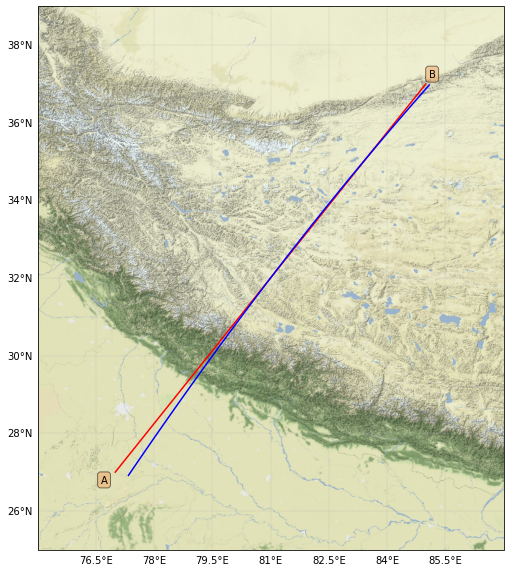

In [61]:
# plotting profile
ax_set_extent = [profile_lon1-2, profile_lon2+2, profile_lat1-2, profile_lat2+2]
fig = plt.figure(figsize=(20, 10))
stamen_terrain = cimgt.Stamen('terrain-background') # Create a Stamen terrain background instance.
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(ax_set_extent, crs=ccrs.PlateCarree())
ax.coastlines(resolution = '50m', linewidth = 1)
ax.add_image(stamen_terrain, 8) # Add the Stamen data at zoom level 8.

# grid line settings
gl=ax.gridlines(linewidth = 0.2, draw_labels = True)
gl.top_labels = False
gl.right_labels = False

# drawing profile
ax.plot([profile_lon1, profile_lon2], [profile_lat1, profile_lat2], 'r', transform=ccrs.PlateCarree())
ax.text(profile_lon1-0.2, profile_lat1-0.2, u'A',
        verticalalignment='center', horizontalalignment='right',
        bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
ax.text(profile_lon2+0.25, profile_lat2+0.25, u'B',
        verticalalignment='center', horizontalalignment='right',
        bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
# plotting profile coords
ax.plot(profile_coords[:,0], profile_coords[:,1], 'b', transform=ccrs.PlateCarree())

#### Creating Annulus profile

In [62]:
!./create_annulus_profile.sh
!awk '{print $1 = ((6371.0-$4)/6371.0), $2 = -$5, $3 = ((0.5*$3*3300)/100)}' ./pre_proc_dir/profile_tomo.txt | \
    awk '{print $1, $2=90+$2, $3}' | column -t > ./pre_proc_dir/annulus_profile_tomo.txt
!cp ./pre_proc_dir/annulus_profile_tomo.txt ./output_dir/

0.0
22.6
67.8
112.9
158.1
203.3
248.5
293.7
338.8
384.0
429.2
474.4
519.6
564.7
609.9
655.1
700.3
745.5
790.6
835.8
881.0
926.2
971.4
1016.5
1061.7
1106.9
1152.1
1197.3
1242.4
1287.6
1332.8
1378.0
1423.2
1468.3
1513.5
1558.7
1603.9
1649.1
1694.2
1739.4
1784.6
1829.8
1875.0
1920.1
1965.3
2010.5
2055.7
2100.9
2146.0
2191.2
2236.4
2281.6
2326.8
2371.9
2417.1
2462.3
2507.5
2552.7
2597.8
2643.0
2688.2
2733.4
2778.6
2823.7
2868.9
2891.0


#### Creating cartesian profile

In [63]:
!awk '{if($4 <= 660) print $1, $2, $3, $4, $5}' ./pre_proc_dir/profile_tomo.txt | column -t > \
    ./pre_proc_dir/profile_tomo_660.txt
!awk '{print $1 = ($5+6.0)/6, $2 = ((660.0-$4)/660.0), $3 = ((0.5*$3*3300)/100)}' \
    ./pre_proc_dir/profile_tomo_660.txt | column -t > ./pre_proc_dir/cart_profile_tomo_660.txt
!cp ./pre_proc_dir/cart_profile_tomo_660.txt ./output_dir/

In [64]:
# removing pre process data dir
!rm -rf pre_proc_dir